In [13]:
import pandas as pd
import numpy as np

## Cargamos los datos

Cargamos los datos de ratings, books, tags y book_tags, generando un dataframe ratings_matrix, que será matriz R que vamos a usar para el modelo de KNN.

In [14]:
ratings = pd.read_csv('./data/ratings.csv')
to_read = pd.read_csv('./data/to_read.csv')
books = pd.read_csv('./data/books.csv')
book_tags = pd.read_csv('./data/book_tags.csv')
tags = pd.read_csv('./data/tags.csv')

print("Ratings shape:", ratings.shape)
print("Books shape:", books.shape)
print("Tags shape:", tags.shape)

Ratings shape: (5976479, 3)
Books shape: (10000, 23)
Tags shape: (34252, 2)


In [15]:
# Generamos la matriz de ratings, que será una matriz libros x usuario, vemos que ocupa 4 GB

ratings_matrix = ratings.pivot(index='user_id', columns='book_id', values='rating')
ratings_matrix.info( memory_usage='deep' )

<class 'pandas.core.frame.DataFrame'>
Index: 53424 entries, 1 to 53424
Columns: 10000 entries, 1 to 10000
dtypes: float64(10000)
memory usage: 4.0 GB


# Generación de muestras.



In [16]:
# Muestra aleatoria de 1000 usuarios y 1000 libros (7.6 MB)

N = 1000 # Número de usuarios
M = 1000 # Número de libros

ratings_matrix_sample = ratings_matrix.sample(N, axis=0).sample(M, axis=1)
ratings_matrix_sample.info( memory_usage='deep' )

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 48037 to 33778
Columns: 1000 entries, 9958 to 4780
dtypes: float64(1000)
memory usage: 7.6 MB


In [17]:
# Muestra de 10 usuario y 1000 libros que intenta estar lo mas poblada posible para garantizar que haya coincidencias entre usuarios (85.9 KB)

N = 10 # Número de usuarios
M = 1000 # Número de libros

# Selecciona los 10 usuarios con más valoraciones
usuarios_top = ratings_matrix_sample.notna().sum(axis=1).sort_values(ascending=False).head(N).index

# Selecciona los 1000 libros con más valoraciones
libros_top = ratings_matrix_sample.notna().sum(axis=0).sort_values(ascending=False).head(M).index

mini_sample = ratings_matrix_sample.loc[usuarios_top, libros_top]
mini_sample.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 16166 to 48825
Columns: 1000 entries, 11 to 8574
dtypes: float64(1000)
memory usage: 78.2 KB


In [18]:
# Muestra de 1000 usuario y 1000 libros que intenta estar lo mas poblada posible para garantizar que haya coincidencias entre usuarios (7.6 MB)

N = 1000 # Número de usuarios
M = 1000 # Número de libros

# Selecciona los 10 usuarios con más valoraciones
usuarios_top = ratings_matrix_sample.notna().sum(axis=1).sort_values(ascending=False).head(M).index

# Selecciona los 1000 libros con más valoraciones
libros_top = ratings_matrix_sample.notna().sum(axis=0).sort_values(ascending=False).head(N).index

mid_sample = ratings_matrix_sample.loc[usuarios_top, libros_top]
mid_sample.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 16166 to 11620
Columns: 1000 entries, 11 to 8574
dtypes: float64(1000)
memory usage: 7.6 MB


A continuación se definen las funciones que se van a usar para el modelo de KNN. Y se hacen pruebas con la muestra de 10 usuarios y 1000 libros.

## Media de un usuario

In [19]:
def media_usuario(user_id, matrix = ratings_matrix):
    """Devuelve la puntuación media de un usuario usando"""
    if user_id not in matrix.index:
        return None
    ratings = matrix.loc[user_id].dropna()
    if len(ratings) == 0:
        return None
    return np.mean(ratings)

In [20]:
usuarios = mini_sample.index

print("Media de un usuario:", media_usuario(usuarios[0], mini_sample))

Media de un usuario: 3.875


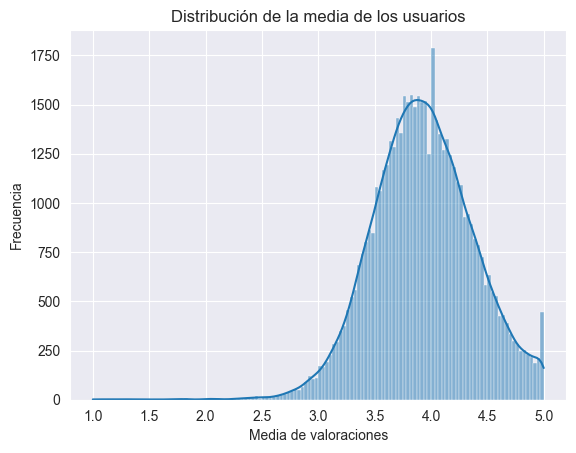

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(ratings_matrix.mean(axis=1), kde=True)
plt.title('Distribución de la media de los usuarios')
plt.xlabel('Media de valoraciones')
plt.ylabel('Frecuencia')
plt.show()

## Similitud entre usuarios (Jaccard-MSD)

In [22]:
def jmsd_similarity(u, v, matrix=ratings_matrix, print=False):
    """
    Calcula la similitud JMSD entre dos usuarios (u, v) en una matriz libros x usuarios.
    """
    if u not in matrix.index or v not in matrix.index:
        if print:
            print('usuario no encontrado')
        return None

    ratings_u = matrix.loc[u]
    ratings_v = matrix.loc[v]

    # Selecciona solo los libros que ambos han valorado
    mask = ratings_u.notna() & ratings_v.notna()
    if mask.sum() == 0:
        if print:
            print('no hay libros en común')
        return None

    r_u = ratings_u[mask]
    r_v = ratings_v[mask]

    # Normaliza las valoraciones
    MIN_RATING = matrix.min().min()
    MAX_RATING = matrix.max().max()
    r_u_norm = (r_u - MIN_RATING) / (MAX_RATING - MIN_RATING)
    r_v_norm = (r_v - MIN_RATING) / (MAX_RATING - MIN_RATING)

    msd = np.mean((r_u_norm - r_v_norm) ** 2)
    jaccard = mask.sum() / ((ratings_u.notna() | ratings_v.notna()).sum())

    return jaccard * (1 - msd)

In [23]:
users = mini_sample.index
jmsd_similarity(users[1], users[2], ratings_matrix_sample)

np.float64(0.053125000000000006)

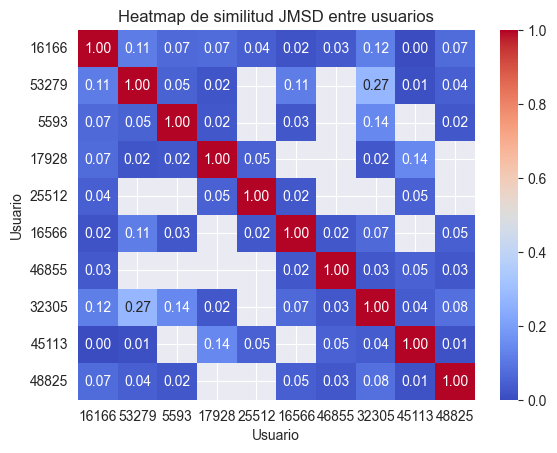

In [24]:
# Vamos a generar un heatmap de similitud entre usuarios
usuarios = mini_sample.index

sim_matrix = np.zeros((len(usuarios), len(usuarios)))

for i, u1 in enumerate(usuarios):
    for j, u2 in enumerate(usuarios):
        if i <= j:
            sim = jmsd_similarity(u1, u2, mini_sample)
            sim_matrix[i, j] = sim
            sim_matrix[j, i] = sim  # simétrica


sim_df = pd.DataFrame(sim_matrix, index=usuarios, columns=usuarios)

sns.heatmap(sim_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap de similitud JMSD entre usuarios")
plt.xlabel("Usuario")
plt.ylabel("Usuario")
plt.show()



## Buscar los k vecinos más cercanos

In [25]:
from tqdm import tqdm

In [26]:
def k_nearest_neighbors(user_id, k=5, matrix=ratings_matrix, use_tqdm=True):
    """
    Devuelve los k vecinos más cercanos a un usuario dado en una matriz libros x usuarios.
    """
    if user_id not in matrix.index:
        print('usuario no encontrado')
        return None

    similarities = []

    if use_tqdm:
        iterador = tqdm(matrix.index)
    else:
        iterador = matrix.index

    for other_user in iterador:
        if other_user != user_id:
            sim = jmsd_similarity(user_id, other_user, matrix)
            if sim is not None:
                similarities.append((other_user, sim))

    # Ordena por similitud y selecciona los k más cercanos
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:k]

In [27]:
usuarios = mid_sample.index

k_nearest_neighbors(usuarios[0], k=5, matrix=mid_sample)

100%|██████████| 1000/1000 [00:11<00:00, 84.53it/s]


[(16992, np.float64(0.18548387096774194)),
 (5794, np.float64(0.18125000000000002)),
 (30451, np.float64(0.166015625)),
 (7256, np.float64(0.1575)),
 (24781, np.float64(0.15277777777777776))]

In [27]:
usuarios = ratings_matrix.index

k_nearest_neighbors(usuarios[0], k=5, matrix=ratings_matrix)

# Como vemos la matriz de 4GB es muy grande para ejecutar KNN en un tiempo razonable.

  0%|          | 1/53424 [00:13<194:35:47, 13.11s/it]

KeyboardInterrupt


KeyboardInterrupt



## Estimar predicciones

In [28]:
def deviation_from_mean_prediction(usuario, libro, neighbors, matrix=ratings_matrix_sample):
    """
    Devuelve la predicción de un libro para un usuario dado usando el método de desviación de la media.
    """
    acc = 0
    count = 0

    for n in neighbors:
        if n is None:
            break
        # Verifica si el vecino tiene valoración para el libro i
        if libro in matrix.columns and not pd.isna(matrix.loc[n, libro]):
            avg_n = media_usuario(n, matrix)
            acc += matrix.loc[n, libro] - avg_n
            count += 1

    if count > 0:
        avg_u = media_usuario(usuario, matrix)
        prediction = avg_u + acc / count
        return prediction
    else:
        #print('No hay vecinos con valoraciones para el libro')
        return None

ERROR! Session/line number was not unique in database. History logging moved to new session 466


In [29]:
usuarios = mini_sample.index
libros = mini_sample.columns

usuario = usuarios[0]
libro = libros[0]

In [30]:
vecinos = k_nearest_neighbors(usuario, k=25, matrix=ratings_matrix_sample)
vecinos_id = [n[0] for n in vecinos]

100%|██████████| 1000/1000 [00:12<00:00, 81.31it/s]


In [31]:
pred = deviation_from_mean_prediction(usuario, libro, vecinos_id, matrix=ratings_matrix_sample)

In [33]:
# Aqui vemos que podemos predecir la puntuación de un libro para un usuario dado.

for libro in libros:
    pred = deviation_from_mean_prediction(usuario, libro, vecinos_id, matrix=ratings_matrix_sample)
    if pred is not None:
        print(f"Predicción para el libro {libro}: {pred:.2f}")
    else:
        pass
        # print(f"No se pudo hacer la predicción para el libro {libro}")

Predicción para el libro 11: 4.05
Predicción para el libro 47: 4.31
Predicción para el libro 38: 4.37
Predicción para el libro 65: 4.41
Predicción para el libro 133: 4.43
Predicción para el libro 73: 3.43
Predicción para el libro 95: 4.29
Predicción para el libro 89: 4.41
Predicción para el libro 82: 3.73
Predicción para el libro 178: 3.83
Predicción para el libro 277: 2.38
Predicción para el libro 339: 4.73
Predicción para el libro 249: 3.96
Predicción para el libro 199: 4.43
Predicción para el libro 145: 0.78
Predicción para el libro 287: 2.47
Predicción para el libro 242: 4.54
Predicción para el libro 241: 4.07
Predicción para el libro 468: 3.35
Predicción para el libro 187: 2.54
Predicción para el libro 283: 3.57
Predicción para el libro 379: 4.61
Predicción para el libro 456: 4.31
Predicción para el libro 646: 4.38
Predicción para el libro 360: 3.90
Predicción para el libro 261: 3.30
Predicción para el libro 529: 3.78
Predicción para el libro 417: 3.54
Predicción para el libro 377

In [35]:
def get_predictions(usuario, libros, vecinos_id, matrix):
    """
    Devuelve todas las predicciones ordenadas de un usuario (prediccion, libro).
    """
    predicciones = []

    for libro in libros:
        pred = deviation_from_mean_prediction(usuario, libro, vecinos_id, matrix=matrix)
        if pred is not None:
            predicciones.append((libro, pred))
        # Si es None, simplemente no se añade

    # Ordena por la predicción (valor), de mayor a menor, y toma los n primeros
    return sorted(predicciones, key=lambda x: x[1], reverse=True)

In [36]:
get_predictions(usuario, libros, vecinos_id, ratings_matrix_sample)

[(629, np.float64(5.652777777777778)),
 (6990, np.float64(5.375)),
 (5615, np.float64(5.125)),
 (5029, np.float64(5.125)),
 (4638, np.float64(5.110294117647059)),
 (5508, np.float64(4.958333333333334)),
 (2729, np.float64(4.951923076923077)),
 (7440, np.float64(4.951923076923077)),
 (1486, np.float64(4.896428571428571)),
 (1317, np.float64(4.875)),
 (6863, np.float64(4.875)),
 (3853, np.float64(4.805555555555555)),
 (3388, np.float64(4.784090909090909)),
 (3735, np.float64(4.784090909090909)),
 (4187, np.float64(4.784090909090909)),
 (4136, np.float64(4.784090909090909)),
 (7210, np.float64(4.784090909090909)),
 (4753, np.float64(4.775)),
 (339, np.float64(4.732142857142857)),
 (708, np.float64(4.652777777777778)),
 (431, np.float64(4.632516339869281)),
 (274, np.float64(4.626262626262626)),
 (379, np.float64(4.611742424242424)),
 (699, np.float64(4.591577540106952)),
 (2611, np.float64(4.589285714285714)),
 (3544, np.float64(4.589285714285714)),
 (1380, np.float64(4.580882352941177)),

## Conseguir recomendaciones

In [38]:
def get_recommendations (usuario, sample_libros, vecinos_id, ratings_matrix_sample, n=10):

    prediccciones = get_predictions(usuario, sample_libros, vecinos_id, ratings_matrix_sample)
    return prediccciones[:n] # Devuelve las 5 mejores recomendaciones

get_recommendations(usuario, libros, vecinos_id, ratings_matrix_sample, n=10)

[(629, np.float64(5.652777777777778)),
 (6990, np.float64(5.375)),
 (5615, np.float64(5.125)),
 (5029, np.float64(5.125)),
 (4638, np.float64(5.110294117647059)),
 (5508, np.float64(4.958333333333334)),
 (2729, np.float64(4.951923076923077)),
 (7440, np.float64(4.951923076923077)),
 (1486, np.float64(4.896428571428571)),
 (1317, np.float64(4.875))]

## Rellenar la matriz de ratings con las predicciones (Lo usaremos para evaluar el modelo)

In [39]:
import pandas as pd
import numpy as np

def generar_matriz_predicciones(matrix, k=10):
    usuarios = matrix.index
    libros = matrix.columns
    # Inicializa la matriz de predicciones con None
    pred_matrix = pd.DataFrame(None, index=usuarios, columns=libros)

    for usuario in tqdm(usuarios):
        vecinos = k_nearest_neighbors(usuario, k=k, matrix=matrix, use_tqdm=False)
        vecinos_id = [n[0] for n in vecinos]
        for libro in libros:
            pred = deviation_from_mean_prediction(usuario, libro, vecinos_id, matrix=matrix)
            if pred is not None:
                pred_matrix.loc[usuario, libro] = pred
    return pred_matrix

In [40]:
pred_mini_sample = generar_matriz_predicciones(mini_sample, k=5)

100%|██████████| 10/10 [00:00<00:00, 14.34it/s]


In [41]:
pred_mid_sample = generar_matriz_predicciones(mid_sample, k=5)

  0%|          | 3/1000 [00:33<3:06:29, 11.22s/it]


KeyboardInterrupt: 

# A continuacion las funciones que vamos a usar para evaluar el modelo.

## Calcular RMSE y MAE

In [42]:
def calcular_errores(matrix_real, matrix_pred):
    errores = []
    for usuario in matrix_real.index:
        for libro in matrix_real.columns:
            real = matrix_real.loc[usuario, libro]
            pred = matrix_pred.loc[usuario, libro]
            if not (pd.isna(real) or pd.isna(pred)):
                errores.append(abs(real - pred))
    if errores:
        return errores
    else:
        return None

def calcular_mae(errores):
    return np.mean(errores)

def calcular_rmse(errores):
    return np.sqrt(np.mean(np.square(errores)))


# Pequeño test
errores = calcular_errores(mini_sample, pred_mini_sample)
mae = calcular_mae(errores)
rmse = calcular_rmse(errores)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.8448675666438823
RMSE: 1.1706694917394902


## Precision

In [43]:
def get_user_precision(user_id, pred_matrix, test_matrix, theta=4, n=10):

    # Selecciona los libros con mayor predicción para el usuario
    user_preds = pred_matrix.loc[user_id].dropna().sort_values(ascending=False)
    top_n_books = user_preds.head(n).index

    precision = 0
    count = 0

    for book_id in top_n_books:
        real_rating = test_matrix.loc[user_id, book_id]
        if not np.isnan(real_rating):
            if real_rating >= theta:
                precision += 1
            count += 1

    if count > 0:
        return precision / count
    else:
        return None

def get_all_precisions(pred_matrix, test_matrix, theta=4, n=10):
    precisions = []
    for user_id in pred_matrix.index:
        user_precision = get_user_precision(user_id, pred_matrix, test_matrix, theta=theta, n=n)
        if user_precision is not None:
            precisions.append(user_precision)
    return precisions

def get_precision(pred_matrix, test_matrix, theta=4, n=10):
    precisions = get_all_precisions(pred_matrix, test_matrix, theta=theta, n=n)
    if precisions:
        return np.mean(precisions)
    else:
        return None

# Pequeño test
usuarios = mini_sample.index
precision_lista = get_all_precisions(pred_mini_sample, mini_sample, theta=4, n=10)
precision_media = get_precision(pred_mini_sample, mini_sample, theta=4, n=10)
print("Precisión por usuario:", precision_lista)
print("Precisión media:", precision_media)

Precisión por usuario: [0.0, 0.0, 1.0, 0.25, 0.0, 1.0]
Precisión media: 0.375


## Recall

In [44]:

import numpy as np

def get_user_recall(user_id, pred_matrix, test_matrix, theta=4, n=10):
    """
    Calcula el recall para un usuario dado.
    """
    # Libros relevantes en test
    relevant_books = test_matrix.loc[user_id][test_matrix.loc[user_id] >= theta].dropna().index
    if len(relevant_books) == 0:
        return None

    # Libros recomendados (top-n predicciones)
    user_preds = pred_matrix.loc[user_id].dropna().sort_values(ascending=False)
    top_n_books = user_preds.head(n).index

    # Libros relevantes recomendados
    hits = len(set(top_n_books) & set(relevant_books))
    recall = hits / len(relevant_books)
    return recall

def get_all_recalls(pred_matrix, test_matrix, theta=4, n=10):
    recalls = []
    for user_id in pred_matrix.index:
        user_recall = get_user_recall(user_id, pred_matrix, test_matrix, theta=theta, n=n)
        if user_recall is not None:
            recalls.append(user_recall)
    return recalls

def get_recall(pred_matrix, test_matrix, theta=4, n=10):
    recalls = get_all_recalls(pred_matrix, test_matrix, theta=theta, n=n)
    if recalls:
        return np.mean(recalls)
    else:
        return None

recall_lista = get_all_recalls(pred_mini_sample, mini_sample, theta=4, n=10)
recall_media = get_recall(pred_mini_sample, mini_sample, theta=4, n=10)

print("Recall por usuario:", recall_lista)
print("Recall medio:", recall_media)

Recall por usuario: [0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.07142857142857142]
Recall medio: 0.04325396825396825


## F1

In [45]:
def get_user_f1(user_id, pred_matrix, test_matrix, theta=4, n=10):
    precision = get_user_precision(user_id, pred_matrix, test_matrix, theta=theta, n=n)
    recall = get_user_recall(user_id, pred_matrix, test_matrix, theta=theta, n=n)
    if precision is not None and recall is not None and (precision + recall) > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return None

def get_all_f1s(pred_matrix, test_matrix, theta=4, n=10):
    f1s = []
    for user_id in pred_matrix.index:
        f1 = get_user_f1(user_id, pred_matrix, test_matrix, theta=theta, n=n)
        if f1 is not None:
            f1s.append(f1)
    return f1s

def get_f1(pred_matrix, test_matrix, theta=4, n=10):
    f1s = get_all_f1s(pred_matrix, test_matrix, theta=theta, n=n)
    if f1s:
        return np.mean(f1s)
    else:
        return None

f1_lista = get_all_f1s(pred_mini_sample, mini_sample, theta=4, n=10)
f1_media = get_f1(pred_mini_sample, mini_sample, theta=4, n=10)
print("F1 por usuario:", f1_lista)
print("F1 medio:", f1_media)


F1 por usuario: [0.19999999999999998, 0.25, 0.13333333333333333]
F1 medio: 0.19444444444444442


## nDGCG

In [46]:
import numpy as np

def dcg_at_n(relevancias):
    return np.sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(relevancias)])

def get_user_ndcg(user_id, pred_matrix, test_matrix, n=10):
    # Libros predichos ordenados por predicción
    user_preds = pred_matrix.loc[user_id].dropna().sort_values(ascending=False)
    top_n_books = user_preds.head(n).index

    # Relevancias reales de los libros recomendados
    relevancias = []
    for book_id in top_n_books:
        real_rating = test_matrix.loc[user_id, book_id]
        if not np.isnan(real_rating):
            relevancias.append(real_rating)
        else:
            relevancias.append(0)  # Si no hay rating, se asume 0

    dcg = dcg_at_n(relevancias)

    # Ideal DCG: relevancias reales ordenadas de mayor a menor
    user_real = test_matrix.loc[user_id].dropna().sort_values(ascending=False)
    ideal_relevancias = user_real.head(n).values
    idcg = dcg_at_n(ideal_relevancias)

    if idcg == 0:
        return None
    return dcg / idcg

def get_all_ndcgs(pred_matrix, test_matrix, n=10):
    ndcgs = []
    for user_id in pred_matrix.index:
        ndcg = get_user_ndcg(user_id, pred_matrix, test_matrix, n=n)
        if ndcg is not None:
            ndcgs.append(ndcg)
    return ndcgs

def get_ndcg(pred_matrix, test_matrix, n=10):
    ndcgs = get_all_ndcgs(pred_matrix, test_matrix, n=n)
    if ndcgs:
        return np.mean(ndcgs)
    else:
        return None

# Ejemplo de uso:
ndcg_lista = get_all_ndcgs(pred_mini_sample, mini_sample, n=10)
ndcg_media = get_ndcg(pred_mini_sample, mini_sample, n=10)
print("nDCG por usuario:", ndcg_lista)
print("nDCG medio:", ndcg_media)

nDCG por usuario: [np.float64(0.030348030527338782), np.float64(0.00837397191695658), np.float64(0.27656520439413435), np.float64(0.0), np.float64(0.0), np.float64(0.2233253317906144), np.float64(0.0), np.float64(0.07439771956824517), np.float64(0.0), np.float64(0.04791016450960245)]
nDCG medio: 0.06609204227068917


## Calculo final de metricas:

Usando la muestra mediana calculamos las métricas del modelo.

In [47]:
pred_mid_matrix = generar_matriz_predicciones(mid_sample, k=5)

100%|██████████| 1000/1000 [1:30:01<00:00,  5.40s/it]


In [48]:
# Calcula métricas solo sobre mid_sample y sus predicciones
errores = calcular_errores(mid_sample, pred_mid_matrix)
mae = calcular_mae(errores)
rmse = calcular_rmse(errores)
precision_media = get_precision(pred_mid_matrix, mid_sample, theta=4, n=10)
recall_media = get_recall(pred_mid_matrix, mid_sample, theta=4, n=10)
f1_media = get_f1(pred_mid_matrix, mid_sample, theta=4, n=10)
ndcg_media = get_ndcg(pred_mid_matrix, mid_sample, n=10)

print("MAE:", mae)
print("RMSE:", rmse)
print("Precisión media:", precision_media)
print("Recall medio:", recall_media)
print("F1 medio:", f1_media)
print("nDCG medio:", ndcg_media)

MAE: 0.6787764434930948
RMSE: 0.8785725163322704
Precisión media: 0.8281372549019609
Recall medio: 0.23945233469629504
F1 medio: 0.42533992453911285
nDCG medio: 0.18021692356664107
